<a href="https://colab.research.google.com/github/carp-x/ML_Colab/blob/main/minitaur_/minitaur_ddpg_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **install**

In [ ]:
!pip install pybullet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 91.7 MB 1.9 MB/s 


In [ ]:
!pip install ptan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.7 MB 4.5 kB/s 
  Created wheel for ptan: filename=ptan-0.7-py3-none-any.whl size=23505 sha256=a6d26bc7dd3de2a02d8006f8aa02df7ee09bfdce50fca9067e831599c61ba3cc
  Stored in directory: /root/.cache/pip/wheels/60/72/3d/a3c47193fdb9efd08e3a54398af996b2989c68571813a71256
Successfully built ptan
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.7.0 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torc

In [ ]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 9.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


# **explore**

In [ ]:
import gym
import pybullet_envs

env = gym.make("MinitaurBulletEnv-v0")

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


(720, 960, 3)


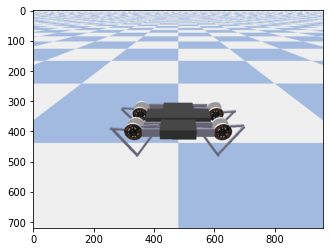

In [ ]:
xxx = env.render('rgb_array')
print(xxx.shape)

import matplotlib.pyplot as plt
plt.imshow(xxx)

In [ ]:
# video recorder import
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# video -> html function
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
# video record

minitaur_training = "minitaur_training.mp4"
video = VideoRecorder(env, minitaur_training)

state = env.reset()
done = False
while not done:
  env.render()
  video.capture_frame()
  action = env.action_space.sample()
  _, _, done, info = env.step(action)

  pass

env.render()
video.capture_frame()

video.close()
env.close()

In [ ]:
# video play

from IPython.display import HTML
html = render_mp4(minitaur_training)
HTML(html)

# **model**

In [ ]:
# model

import ptan
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

HID_SIZE = 128


class ModelA2C(nn.Module):
    def __init__(self, obs_size, act_size):
        super(ModelA2C, self).__init__()

        self.base = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
        )
        self.mu = nn.Sequential(
            nn.Linear(HID_SIZE, act_size),
            nn.Tanh(),
        )
        self.var = nn.Sequential(
            nn.Linear(HID_SIZE, act_size),
            nn.Softplus(),
        )
        self.value = nn.Linear(HID_SIZE, 1)

    def forward(self, x):
        base_out = self.base(x)
        return self.mu(base_out), self.var(base_out), \
               self.value(base_out)


class DDPGActor(nn.Module):
    def __init__(self, obs_size, act_size):
        super(DDPGActor, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(obs_size, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, act_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


class DDPGCritic(nn.Module):
    def __init__(self, obs_size, act_size):
        super(DDPGCritic, self).__init__()

        self.obs_net = nn.Sequential(
            nn.Linear(obs_size, 400),
            nn.ReLU(),
        )

        self.out_net = nn.Sequential(
            nn.Linear(400 + act_size, 300),
            nn.ReLU(),
            nn.Linear(300, 1)
        )

    def forward(self, x, a):
        obs = self.obs_net(x)
        return self.out_net(torch.cat([obs, a], dim=1))


class D4PGCritic(nn.Module):
    def __init__(self, obs_size, act_size,
                 n_atoms, v_min, v_max):
        super(D4PGCritic, self).__init__()

        self.obs_net = nn.Sequential(
            nn.Linear(obs_size, 400),
            nn.ReLU(),
        )

        self.out_net = nn.Sequential(
            nn.Linear(400 + act_size, 300),
            nn.ReLU(),
            nn.Linear(300, n_atoms)
        )

        delta = (v_max - v_min) / (n_atoms - 1)
        self.register_buffer("supports", torch.arange(
            v_min, v_max + delta, delta))

    def forward(self, x, a):
        obs = self.obs_net(x)
        return self.out_net(torch.cat([obs, a], dim=1))

    def distr_to_q(self, distr):
        weights = F.softmax(distr, dim=1) * self.supports
        res = weights.sum(dim=1)
        return res.unsqueeze(dim=-1)


class AgentA2C(ptan.agent.BaseAgent):
    def __init__(self, net, device="cpu"):
        self.net = net
        self.device = device

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)

        mu_v, var_v, _ = self.net(states_v)
        mu = mu_v.data.cpu().numpy()
        sigma = torch.sqrt(var_v).data.cpu().numpy()
        actions = np.random.normal(mu, sigma)
        actions = np.clip(actions, -1, 1)
        return actions, agent_states


class AgentDDPG(ptan.agent.BaseAgent):
    """
    Agent implementing Orstein-Uhlenbeck exploration process
    """
    def __init__(self, net, device="cpu", ou_enabled=True,
                 ou_mu=0.0, ou_teta=0.15, ou_sigma=0.2,
                 ou_epsilon=1.0):
        self.net = net
        self.device = device
        self.ou_enabled = ou_enabled
        self.ou_mu = ou_mu
        self.ou_teta = ou_teta
        self.ou_sigma = ou_sigma
        self.ou_epsilon = ou_epsilon

    def initial_state(self):
        return None

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)
        mu_v = self.net(states_v)
        actions = mu_v.data.cpu().numpy()

        if self.ou_enabled and self.ou_epsilon > 0:
            new_a_states = []
            for a_state, action in zip(agent_states, actions):
                if a_state is None:
                    a_state = np.zeros(
                        shape=action.shape, dtype=np.float32)
                a_state += self.ou_teta * (self.ou_mu - a_state)
                a_state += self.ou_sigma * np.random.normal(
                    size=action.shape)

                action += self.ou_epsilon * a_state
                new_a_states.append(a_state)
        else:
            new_a_states = agent_states

        actions = np.clip(actions, -1, 1)
        return actions, new_a_states


class AgentD4PG(ptan.agent.BaseAgent):
    """
    Agent implementing noisy agent
    """
    def __init__(self, net, device="cpu", epsilon=0.3):
        self.net = net
        self.device = device
        self.epsilon = epsilon

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)
        mu_v = self.net(states_v)
        actions = mu_v.data.cpu().numpy()
        actions += self.epsilon * np.random.normal(
            size=actions.shape)
        actions = np.clip(actions, -1, 1)
        return actions, agent_states

# **common**

In [ ]:
import numpy as np
import torch
from torch.autograd import Variable

import ptan


def unpack_batch_a2c(batch, net, last_val_gamma, device="cpu"):
    """
    Convert batch into training tensors
    :param batch:
    :param net:
    :return: states variable, actions tensor, reference values variable
    """
    states = []
    actions = []
    rewards = []
    not_done_idx = []
    last_states = []
    for idx, exp in enumerate(batch):
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        if exp.last_state is not None:
            not_done_idx.append(idx)
            last_states.append(exp.last_state)
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = torch.FloatTensor(actions).to(device)

    # handle rewards
    rewards_np = np.array(rewards, dtype=np.float32)
    if not_done_idx:
        last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
        last_vals_v = net(last_states_v)[2]
        last_vals_np = last_vals_v.data.cpu().numpy()[:, 0]
        rewards_np[not_done_idx] += last_val_gamma * last_vals_np

    ref_vals_v = torch.FloatTensor(rewards_np).to(device)
    return states_v, actions_v, ref_vals_v


def unpack_batch_ddqn(batch, device="cpu"):
    states, actions, rewards, dones, last_states = [], [], [], [], []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        dones.append(exp.last_state is None)
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = ptan.agent.float32_preprocessor(actions).to(device)
    rewards_v = ptan.agent.float32_preprocessor(rewards).to(device)
    last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
    dones_t = torch.BoolTensor(dones).to(device)
    return states_v, actions_v, rewards_v, dones_t, last_states_v

# **import & define**

In [ ]:
import os
import ptan
import time
import gym
import pybullet_envs
# import argparse
from tensorboardX import SummaryWriter
import numpy as np

# from lib import model, common

import torch
import torch.optim as optim
import torch.nn.functional as F


ENV_ID = "MinitaurBulletEnv-v0"
GAMMA = 0.99
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
REPLAY_SIZE = 100000
REPLAY_INITIAL = 10000

TEST_ITERS = 1000


def test_net(net, env, count=10, device="cpu"):
    rewards = 0.0
    steps = 0
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = ptan.agent.float32_preprocessor([obs]).to(device)
            mu_v = net(obs_v)
            action = mu_v.squeeze(dim=0).data.cpu().numpy()
            action = np.clip(action, -1, 1)
            obs, reward, done, _ = env.step(action)
            rewards += reward
            steps += 1
            if done:
                break
    return rewards / count, steps / count


In [ ]:
# cuda or not

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:",torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: Tesla P100-PCIE-16GB


device(type='cuda')

In [ ]:
"""
parser = argparse.ArgumentParser()
parser.add_argument("--cuda", default=False, action='store_true', help='Enable CUDA')
parser.add_argument("-n", "--name", required=True, help="Name of the run")
args = parser.parse_args()
device = torch.device("cuda" if args.cuda else "cpu")
"""

save_path = os.path.join('mount/My Drive/Colab Notebooks/minitaur_', '01_22053122')
os.makedirs(save_path, exist_ok=True)


env = gym.make(ENV_ID)
test_env = gym.make(ENV_ID)

act_net = DDPGActor(
    env.observation_space.shape[0],
    env.action_space.shape[0]).to(device)
crt_net = DDPGCritic(
    env.observation_space.shape[0],
    env.action_space.shape[0]).to(device)
print(act_net)
print(crt_net)
tgt_act_net = ptan.agent.TargetNet(act_net)
tgt_crt_net = ptan.agent.TargetNet(crt_net)

writer = SummaryWriter(comment="-ddpg_")
agent = AgentDDPG(act_net, device=device)
exp_source = ptan.experience.ExperienceSourceFirstLast(
    env, agent, gamma=GAMMA, steps_count=1)
buffer = ptan.experience.ExperienceReplayBuffer(
    exp_source, buffer_size=REPLAY_SIZE)
act_opt = optim.Adam(act_net.parameters(), lr=LEARNING_RATE)
crt_opt = optim.Adam(crt_net.parameters(), lr=LEARNING_RATE)

current_dir=/usr/local/lib/python3.7/dist-packages/pybullet_envs/bullet
urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data
urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


DDPGActor(
  (net): Sequential(
    (0): Linear(in_features=28, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=8, bias=True)
    (5): Tanh()
  )
)
DDPGCritic(
  (obs_net): Sequential(
    (0): Linear(in_features=28, out_features=400, bias=True)
    (1): ReLU()
  )
  (out_net): Sequential(
    (0): Linear(in_features=408, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=1, bias=True)
  )
)


# **train**

In [ ]:
frame_idx = 0
best_reward = None

In [ ]:
frame_idx = 0
best_reward = None
with ptan.common.utils.RewardTracker(writer) as tracker:
    with ptan.common.utils.TBMeanTracker(
            writer, batch_size=10) as tb_tracker:
        while True:
            frame_idx += 1
            buffer.populate(1)
            rewards_steps = exp_source.pop_rewards_steps()
            if rewards_steps:
                rewards, steps = zip(*rewards_steps)
                tb_tracker.track("episode_steps", steps[0], frame_idx)
                tracker.reward(rewards[0], frame_idx)

            if len(buffer) < REPLAY_INITIAL:
                continue

            batch = buffer.sample(BATCH_SIZE)
            states_v, actions_v, rewards_v, \
            dones_mask, last_states_v = \
                unpack_batch_ddqn(batch, device)

            # train critic
            crt_opt.zero_grad()
            q_v = crt_net(states_v, actions_v)
            last_act_v = tgt_act_net.target_model(
                last_states_v)
            q_last_v = tgt_crt_net.target_model(
                last_states_v, last_act_v)
            q_last_v[dones_mask] = 0.0
            q_ref_v = rewards_v.unsqueeze(dim=-1) + \
                      q_last_v * GAMMA
            critic_loss_v = F.mse_loss(q_v, q_ref_v.detach())
            critic_loss_v.backward()
            crt_opt.step()
            tb_tracker.track("loss_critic",
                              critic_loss_v, frame_idx)
            tb_tracker.track("critic_ref",
                              q_ref_v.mean(), frame_idx)

            # train actor
            act_opt.zero_grad()
            cur_actions_v = act_net(states_v)
            actor_loss_v = -crt_net(states_v, cur_actions_v)
            actor_loss_v = actor_loss_v.mean()
            actor_loss_v.backward()
            act_opt.step()
            tb_tracker.track("loss_actor",
                              actor_loss_v, frame_idx)

            tgt_act_net.alpha_sync(alpha=1 - 1e-3)
            tgt_crt_net.alpha_sync(alpha=1 - 1e-3)

            if frame_idx % TEST_ITERS == 0:
                ####
                if frame_idx % 300000 == 0:
                  act_net_name = os.path.join(save_path, "act_net.pth")
                  crt_net_name = os.path.join(save_path, "crt_net.pth")
                  torch.save(act_net.state_dict(), act_net_name)
                  torch.save(crt_net.state_dict(), crt_net_name)
                ####
                ts = time.time()
                rewards, steps = test_net(act_net, test_env, device=device)
                print("Test done in %.2f sec, reward %.3f, steps %d" % (
                    time.time() - ts, rewards, steps))
                writer.add_scalar("test_reward", rewards, frame_idx)
                writer.add_scalar("test_steps", steps, frame_idx)
                if best_reward is None or best_reward < rewards:
                    if best_reward is not None:
                        print("Best reward updated: %.3f -> %.3f" % (best_reward, rewards))
                        name = "best_%+.3f_%d.dat" % (rewards, frame_idx)
                        fname = os.path.join(save_path, name)
                        torch.save(act_net.state_dict(), fname)
                    best_reward = rewards

# training end

230: done 2 episodes, mean reward -0.219, speed 105.69 f/s
316: done 4 episodes, mean reward -0.147, speed 83.38 f/s
735: done 6 episodes, mean reward -0.227, speed 126.66 f/s
1003: done 8 episodes, mean reward -0.179, speed 118.98 f/s
1128: done 11 episodes, mean reward -0.146, speed 92.24 f/s
1263: done 12 episodes, mean reward -0.133, speed 114.48 f/s
1417: done 13 episodes, mean reward -0.129, speed 117.01 f/s
1633: done 14 episodes, mean reward -0.116, speed 129.37 f/s
1993: done 15 episodes, mean reward -0.137, speed 132.92 f/s
2111: done 16 episodes, mean reward -0.140, speed 111.18 f/s
2231: done 18 episodes, mean reward -0.129, speed 92.91 f/s
2431: done 20 episodes, mean reward -0.130, speed 114.65 f/s
2630: done 21 episodes, mean reward -0.143, speed 120.28 f/s
2726: done 23 episodes, mean reward -0.138, speed 93.35 f/s
2965: done 25 episodes, mean reward -0.127, speed 118.27 f/s
3321: done 26 episodes, mean reward -0.139, speed 121.79 f/s
3444: done 28 episodes, mean reward

# **episode**

In [ ]:
# video recorder import
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# video -> html function
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
# setup env & download model

env = gym.make("MinitaurBulletEnv-v0")

net = DDPGActor(env.observation_space.shape[0], env.action_space.shape[0])
net.load_state_dict(torch.load('mount/My Drive/Colab Notebooks/minitaur_/01_22053122/act_net.pth'))

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<All keys matched successfully>

In [ ]:
# video record

minitaur_training = "minitaur_training.mp4"
video = VideoRecorder(env, minitaur_training)

steps = 0
rewards = 0

state = env.reset()
done = False
while not done:
  env.render()
  video.capture_frame()

  state = torch.tensor(state, dtype=torch.float)
  action_draft = net(state)
  action = action_draft.squeeze(dim=0).data.cpu().numpy()
  action = np.clip(action, -1, 1)
  next_state, reward, done, info = env.step(action)

  state = next_state
  steps += 1
  rewards += reward

  pass

env.render()
video.capture_frame()

video.close()
env.close()

In [ ]:
print('steps:', steps)
print('rewards:', rewards)

steps: 141
rewards: 0.5795669862606598


In [ ]:
# video play

from IPython.display import HTML
html = render_mp4(minitaur_training)
HTML(html)

# **Assess**

In [ ]:
# setup env & download model

env = gym.make("MinitaurBulletEnv-v0")

net = DDPGActor(env.observation_space.shape[0], env.action_space.shape[0])
net.load_state_dict(torch.load('mount/My Drive/Colab Notebooks/minitaur_/01_22053122/act_net.pth'))

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<All keys matched successfully>

In [ ]:
# simulate

rewords_by_episodes = []
steps_by_episodes = []

for i in range(100):

  rewords = 0
  steps = 0

  state = env.reset()
  done = False
  while not done:

    state = torch.tensor(state, dtype=torch.float)
    action_draft = net(state)
    action = action_draft.squeeze(dim=0).data.cpu().numpy()
    action = np.clip(action, -1, 1)
    next_state, reword, done, info = env.step(action)

    state = next_state
    rewords += reword
    steps += 1

    pass

  rewords_by_episodes.append(rewords)
  steps_by_episodes.append(steps)

  pass

env.close()

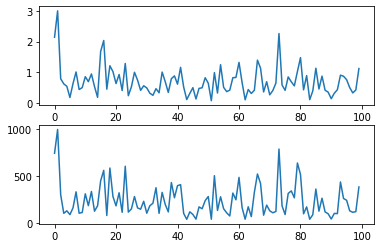

In [ ]:
# plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2)
ax[0].plot(rewords_by_episodes)
ax[1].plot(steps_by_episodes)